In [1]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima_model import ARIMA
import timeit
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from fbprophet import Prophet

C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataprep

In [2]:
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0, usecols=[0,2])

In [3]:
ts.head()

,ice_extent
Year,
1979,12.349634
1980,12.349545
1981,12.147230
1982,12.467336
1983,12.353095


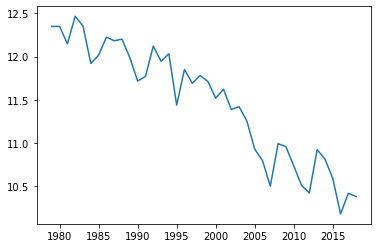

In [4]:
plt.plot(ts)

### Differentiatie

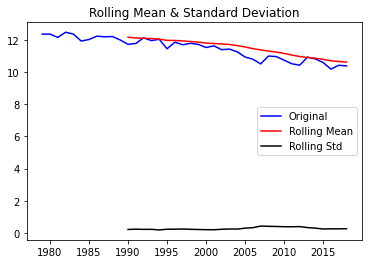

In [5]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(ts)

Duidelijk dalende trend dus passen we differentiatie toe

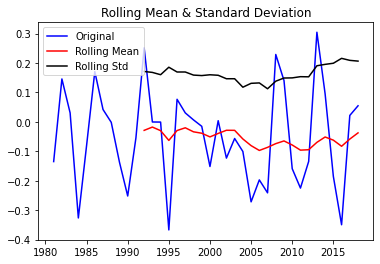

In [6]:
moving_avg = ts.rolling(3).mean()
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff

ts_moving_avg_diff.dropna(inplace=True)

test_stationarity(ts_moving_avg_diff)

Deze data is stationair dus kunnen we modellen beginnen opbouwen

### Cross validation setup

In [7]:
tscv = TimeSeriesSplit(n_splits = 10, max_train_size=35)

In [8]:
for train_index, test_index in tscv.split(ts_moving_avg_diff):
    
    # initialize cross validation train and test sets
    cv_train, cv_test = ts_moving_avg_diff.iloc[train_index], ts_moving_avg_diff.iloc[test_index]
   
    print("TRAIN:", train_index, "TEST:", test_index) # visiualize cross_validation structure for reference

TRAIN: [0 1 2 3 4 5 6 7] TEST: [ 8  9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11 12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26 27 28]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] TEST: [29 30 31]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] TEST: [32 33 34]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] TEST: [35 36 37]


### General methods

In [9]:
def full_graph(predicted, title):
    predictionsArray = np.asarray(predicted)
    zerosArray = np.zeros(ts.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)

    # plot
    plt.title(title)
    plt.plot(ts.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 3 year prediction')
    plt.ylim([0,15])
    plt.legend()

    plt.show()

### ARIMA

----------
IIIIIIIIII
Mean MAE: 0.119°C
MAE of last prediction: 0.066°C
Execution time: 0.767 seconds


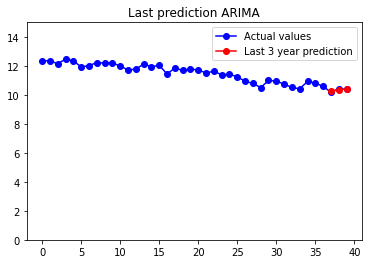

In [10]:
start_time = timeit.default_timer()

pdq = (3,0,0)

warnings.filterwarnings("ignore") # specify to ignore warning messages

print("----------")

maes = []

for train_index, test_index in tscv.split(ts_moving_avg_diff):
    
    # initialize cross validation train and test sets
    cv_train, cv_test = ts_moving_avg_diff.iloc[train_index], ts_moving_avg_diff.iloc[test_index]
   
    # build model
    arima = ARIMA(cv_train, pdq).fit(start_ar_lags=1,disp=False)

    # make predictions
    predictions = arima.forecast(steps=3)
    prediction_values = predictions[0]
    true_values = cv_test.values
    
    # error calc
    maes.append(mean_absolute_error(true_values, prediction_values))
    
    # last actual prediction 
    last_prediction_ARIMA = prediction_values + moving_avg.dropna().iloc[test_index].values.flatten()

    print("I",end="")

time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

print()
print('Mean MAE: %.3f°C' % MAE_ARIMA)
print('MAE of last prediction: %.3f°C' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(last_prediction_ARIMA, 'Last prediction ARIMA')

### LSTM

In [11]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
def build_model(raw_seq, n_steps_in, n_steps_out, n_features):
    # split into samples
    X, y = split_sequence(raw_seq.values.flatten(), n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    
    # fit model
    model.fit(X, y, epochs=50, verbose=0)
    
    return model


def predict(x_input, model, n_features):
    n_features = 1
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

----------
IIIIIIIIII
Mean MAE: 0.184°C
MAE of last prediction: 0.197°C
Execution time: 19.805 seconds


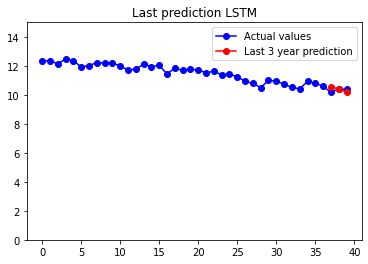

Wall time: 19.9 s


In [12]:
%%time

start_time = timeit.default_timer()

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# variables
n_steps_in = 3
n_steps_out = 3
n_features  = 1
maes = []

print("----------")

for train_index, test_index in tscv.split(ts_moving_avg_diff):
    
    # initialize cross validation train and test sets
    y_train, y_test = ts_moving_avg_diff.iloc[train_index], ts_moving_avg_diff.iloc[test_index]

    # build model
    lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features)

    # make predictions
    x_input = array(y_test)
    y_predicted = predict(x_input, lstm_model, n_features).flatten()
    y_actual = y_test.values
    
    # error calc
    maes.append(mean_absolute_error(y_actual, y_predicted))
    
    print("I",end="")

# last actual prediction 
last_prediction_LSTM = y_predicted + moving_avg.dropna().iloc[test_index].values.flatten()
 
time_LSTM = timeit.default_timer() - start_time
MAE_LSTM = np.mean(maes)
last_MAE_LSTM = maes[-1]

print()
print('Mean MAE: %.3f°C' % MAE_LSTM)
print('MAE of last prediction: %.3f°C' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_prediction_LSTM, 'Last prediction LSTM')

### Prophet

----------


INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


III
Mean MAE: 0.164°C
MAE of last prediction: 0.149°C
Execution time: 51.271 seconds


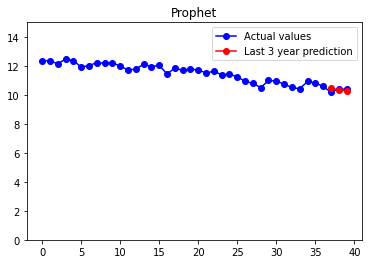

In [14]:
# Disabled tf warning because of clutter
warnings.filterwarnings("ignore") # specify to ignore warning messages

maes = []

# formatting dataframe
ts_formated_prophet = ts_moving_avg_diff.reset_index().rename(columns = {'Year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

print("----------")

for train_index, test_index in tscv.split(ts_formated_prophet):

    # initialize cross validation train and test sets
    train  = ts_formated_prophet.iloc[train_index]
    y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
    X_test = ts_formated_prophet.iloc[test_index][['ds']]
        
    # build model
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(train)

    # make predictions
    forecast = model.predict(X_test)
    y_pred = forecast['yhat'].values
    
    # error calc
    maes.append(mean_absolute_error(y_test, y_pred))
    
    # last actual prediction 
    last_prediction_prophet = y_pred + moving_avg.dropna().iloc[test_index].values.flatten()

    print("I",end="")

time_Prophet = timeit.default_timer() - start_time
MAE_Prophet = np.mean(maes)
last_MAE_Prophet = maes[-1]

print()
print('Mean MAE: %.3f°C' % MAE_Prophet)
print('MAE of last prediction: %.3f°C' % last_MAE_Prophet)
print('Execution time: %.3f seconds' % time_Prophet)
full_graph(last_prediction_prophet, "Prophet")

### Evaluation

In [21]:
results = [[MAE_ARIMA,time_ARIMA,last_MAE_ARIMA],[MAE_LSTM,time_LSTM,last_MAE_LSTM],[MAE_Prophet,time_Prophet,last_MAE_Prophet]]
pd.DataFrame(results, columns=['Mean MAE (°C)','Execution time (s)','Last MAE (°C)'],index=['ARIMA','LSTM','Prophet']).round(decimals=3)


,Mean MAE (°C),Execution time (s),Last MAE (°C)
ARIMA,0.119,0.767,0.066
LSTM,0.184,19.805,0.197
Prophet,0.164,51.271,0.149


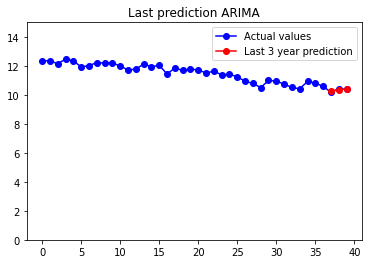

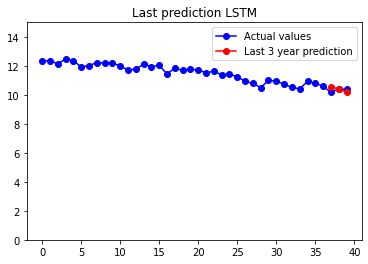

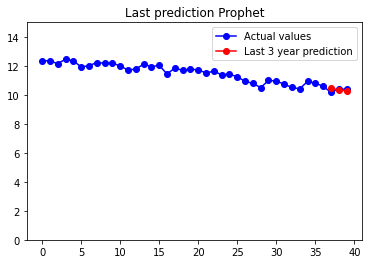

In [16]:
full_graph(last_prediction_ARIMA, "Last prediction ARIMA")
full_graph(last_prediction_LSTM, "Last prediction LSTM")
full_graph(last_prediction_prophet, "Last prediction Prophet")